# Validate SFR

In this case, we will demonstrate how to use AMS and ANDES to mimic the system secondary frequency regulation, where system automatic generation control (AGC) is used to maintain the system frequency at the nominal value.

This demo is prepared by [Jinning Wang](jinningwang.github.io).

Reference:

1. J. Wang et al., "Electric Vehicles Charging Time Constrained Deliverable Provision of Secondary Frequency Regulation," in IEEE Transactions on Smart Grid, doi: [10.1109/TSG.2024.3356948](https://ieeexplore.ieee.org/document/10411057).

In [1]:
import numpy as np
import scipy
import pandas as pd

import ams
import andes

import datetime

import matplotlib
import matplotlib.pyplot as plt

In [2]:
matplotlib.rcdefaults()

In [3]:
%matplotlib inline

In [4]:
print("Last run time:", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

print(f'andes:{andes.__version__}')
print(f'ams:{ams.__version__}')

Last run time: 2024-03-04 11:26:04
andes:1.9.1
ams:0.9.1.post62+gb20e1af


In [5]:
andes.config_logger(stream_level=50)

In [6]:
ams.config_logger(stream_level=30)

## Dispatch case

We use the IEEE 39-bus system as an example.

In [7]:
sp = ams.load(ams.get_case('ieee39/ieee39_uced.xlsx'),
              setup=True,
              no_output=True,)

In [RTED documentation](https://ltb.readthedocs.io/projects/ams/en/stable/typedoc/DCED.html#id24),
we can see that Var ``rgu`` and ``rgd`` are the variables for RegUp/Dn reserve,
and Constraint ``rbu`` and ``rbd`` are the equality constraints for RegUp/Dn reserve balance.

As for the RegUp/Dn reserve requirements, it is defined by parameter ``du`` and ``dd`` as percentage of the total load,
and later ``dud`` and ``ddd`` are the actual reserve requirements.

In [8]:
sp.RTED.dud.v

array([2.34256, 0.     ])

In [9]:
sp.RTED.dd.v

array([0.05, 0.05])

## Dynamic case

In [10]:
sa = sp.to_andes(addfile=andes.get_case('ieee39/ieee39_full.xlsx'),
                 setup=True,
                 no_output=True,
                 default_config=True,
                 )

Following PFlow models in addfile will be overwritten: <Bus>, <PQ>, <PV>, <Slack>, <Shunt>, <Line>, <Area>
AMS system 0x158f6c520 is linked to the ANDES system 0x161e8f7c0.


Device `ACEc` is used to calculate the Area Control Error (ACE).

In [11]:
sa.ACEc.as_df()

,idx,u,name,bus,bias,busf
uid,,,,,,
0,1,1.0,ACE_1,1,300.0,BusFreq_2


## Synthetic load

ISO-NE provides various grid data, such as [Five-Minute System Demand](https://www.iso-ne.com/isoexpress/web/reports/load-and-demand/-/tree/dmnd-five-minute-sys).
In this example, we revise the March 02, 2024, 18 PM data.

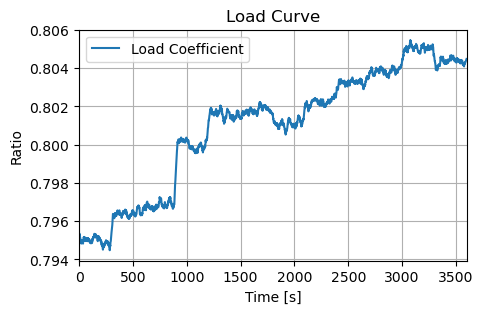

In [14]:
load_isone = np.array([
    11920.071, 11980.979, 12000.579, 12145.243, 12211.862, 12220.703,
    12191.051, 12241.546, 12285.719, 12312.626, 12364.102, 12336.354
])

# Normalize the load
load_min = load_isone.min()
load_max = load_isone.max()
load_mid = (load_max + load_min) / 2  # Midpoint of the range
# Desired range around 0.8
load_range = 0.8 + 0.01 * ((load_isone - load_mid) / (load_max - load_min))

load_scale_base = np.repeat(load_range, 300)

np.random.seed(2024)  # Set random seed for reproducibility
random_bias = np.random.normal(loc=0, scale=0.001,
                               size=len(load_scale_base))

# Add noise to the load as random ACE
load_coeff = load_scale_base + random_bias

# Apply the filter to load_coeff
load_coeff = scipy.signal.savgol_filter(load_coeff, 30, 1)

# Interpolate the load to 3600 points
# load_coeff = np.interp(
#     x=np.linspace(0, 1, num=3600),  # x-coordinates at which to interpolate
#     xp=np.linspace(0, 1, num=len(load_scale)),    # x-coordinates of the data points
#     fp=load_scale,             # y-coordinates of the data points
# )

# load_coeff = load_scale
load_coeff[0:2] = load_coeff[0:300].mean()

# average load every N points, for RTED dispatch
load_coeff_avg = load_coeff.reshape(-1, 300).mean(axis=1)

fig_load, ax_load = plt.subplots(figsize=(5, 3), dpi=100)

ax_load.plot(range(len(load_coeff)), load_coeff,
             label='Load Coefficient')

ax_load.set_xlim([0, 3600])
ax_load.set_xlabel('Time [s]')
ax_load.set_ylabel('Ratio')
ax_load.set_title('Load Curve')
ax_load.grid(True)
ax_load.legend()

## Co-simulation

### Define some constants

Here we assume the AGC interval is 4 seconds, and RTED interval is 300 seconds.

We set the total simulation time to be 400 seconds to cover a dispatch switch.

Between the interoperation of AMS and ANDES, there is a AC conversion step to convert the DC-based dispatch resutls to AC-based power flow results.
For more details, check the reference paper and [dc2ac source code](https://github.com/CURENT/ams/blob/61f7907435092886a1c3175151a17527c64c1db9/ams/routines/rted.py#L184).

### AGC controller

We need to define a PI controller to calculate the control signal for the AGC:

AGC_raw = kp * ACE + ki * integral(ACE)

In the AGC interval, there is a cap operation to limit the AGC signal within procured reserve limits.

### ANDES settings

ANDES load needs to be set to constant load for effective load change.

ANDES output can be adjusted to save memory. This is helpful for performance concerns when the system size is large or the simulation time is long.

In [15]:
# --- time constants ---
total_time = 400

RTED_interval = 300
AGC_interval = 4

id_rted = 0  # RTED interval counter
id_agc = 0  # AGC interval counter

# --- AGC controller ---
kp = 0.1
ki = 0.1

ACE_integral = 0
ACE_raw = 0

# --- initialize output ---
output_cols = ['time', 'freq', 'ACEraw', 'AGCpower', 'pd']
output = np.zeros((total_time, len(output_cols)))

# --- ANDES settings ---
sa.TDS.config.no_tqdm = True  # turn off ANDES progress bar
sa.TDS.config.criteria = 0  # turn off ANDES criteria check

# adjsut ANDES TDS settings to save memory
sa.TDS.config.save_every = 0
# sa.TDS.config.max_store = 100

# use constant power model for PQ
sa.PQ.config.p2p = 1
sa.PQ.config.q2q = 1
sa.PQ.config.p2z = 0
sa.PQ.config.q2z = 0
sa.PQ.pq2z = 0

# save the initial load values
p0_sp = sp.PQ.p0.v.copy()
q0_sp = sp.PQ.q0.v.copy()
p0_sa = sa.PQ.p0.v.copy()
q0_sa = sa.PQ.q0.v.copy()

# save device index
pq_idx = sp.PQ.idx.v  # PQ index
stg_idx = sp.StaticGen.get_idx()  # StaticGen index
# get corresponding governor index
link_table = sp.dyn.link
gov_idx = [link_table.loc[link_table['stg_idx'] == stg, 'gov_idx'].iloc[0] for stg in stg_idx]

### Main loop

In [16]:
for t in range(0, total_time, 1):
    # --- Wathdog ---
    if t % 30 == 0:
        print(f"====== t={t} seconds ======")
        print(f"load factor: {load_coeff[t]:.6f}")

    # --- Dispatch interval ---
    if t % RTED_interval == 0:
        print("------ RTED Interval ------")
        # use 5-min average load in dispatch solution
        load_avg = load_coeff[t:t+RTED_interval].mean()
        # set load in to AMS
        sp.PQ.set(src='p0', attr='v',
                  value=load_avg * p0_sp,
                  idx=pq_idx)
        sp.PQ.set(src='q0', attr='v',
                  value=load_avg * q0_sp,
                  idx=pq_idx)
        sp.RTED.update()

        # run RTED
        sp.RTED.run(solver='ECOS')

        if sp.RTED.exit_code == 0:
            print(f"--AMS: RTED optimized.")
            # calcualte AGC coeff: bu and bd
            pru = sp.RTED.get(src='pru', attr='v', idx=stg_idx)
            prd = sp.RTED.get(src='prd', attr='v', idx=stg_idx)
            bu = pru / pru.sum()
            bd = prd / prd.sum()
        else:
            print(f"--AMS: RTED failed: {sp.RTED.om.prob.status}")
            break

        # convert to AC
        flag_2ac = sp.RTED.dc2ac()
        if flag_2ac:
            print(f"--AMS: AC conversion successful.")
        else:
            print(f"--AMS: AC conversion failed!")
            break

    # --- AGC interval ---
    if t % AGC_interval == 0:
        if ACE_raw > 0:
            AGC_up = bu * np.min([pru.sum(), ACE_raw])
            sa.TurbineGov.set(src='paux0', attr='v', idx=gov_idx,
                              value=AGC_up)
            output[t:t+4, 3] = AGC_up.sum()
        else:
            AGC_up = 0
            AGC_dn = - bd * np.min([prd.sum(), -ACE_raw])
            sa.TurbineGov.set(src='paux0', attr='v', idx=gov_idx,
                              value=AGC_dn)
            output[t:t+4, 3] = AGC_dn.sum()

    # --- TDS interval ---
    if t > 0:
        # --- run TDS ---
        sa.PQ.set(src='Ppf', attr='v', idx=pq_idx,
                  value=load_coeff[t] * p0_sa)
        sa.PQ.set(src='Qpf', attr='v', idx=pq_idx,
                  value=load_coeff[t] * q0_sa)
        sa.TDS.config.tf = t
        sa.TDS.run()
        # Update AGC PI controller
        ACE_integral += sa.ACEc.ace.v.sum()
        ACE_raw = -(kp * sa.ACEc.ace.v.sum() + ki * ACE_integral)
    else:
        # set generation to StaticGen
        sa.StaticGen.set(src='p0', attr='v',
                         value=sp.RTED.pg.v,
                         idx=sp.RTED.pg.get_idx())
        # set bus voltage
        sa.Bus.set(src='v0', attr='v',
                   value=sp.RTED.vBus.v,
                   idx=sp.RTED.vBus.get_idx())
        # set PQ.p0
        sa.PQ.set(src='p0', attr='v', idx=pq_idx,
                value=load_coeff[t] * p0_sa)
        sa.PQ.set(src='q0', attr='v', idx=pq_idx,
                value=load_coeff[t] * q0_sa)
        sa.PFlow.run()  # run power flow
        sa.TDS.init()  # initialize TDS
        print(f"--ANDES: TDS initialized.")

    if sa.exit_code != 0:
        print(f"t={t}, TDS error: {sa.exit_code}")
        break
    else:
        output[t, 0] = t
        output[t, 1] = sa.BusFreq.f.v[1]
        output[t, 2] = ACE_raw
        output[t, 4] = sa.PQ.Ppf.v.sum()

# crop the output with valid time
output = output[0:t, :]

Re-init RTED OModel due to non-parametric change.
RTED solved as optimal in 0.0171 seconds, converged after 11 iterations using solver ECOS.


====== t=0 seconds ======
load factor: 0.794990
------ RTED Interval ------
--AMS: RTED optimized.


<RTED> is converted to AC.


--AMS: AC conversion successful.
--ANDES: TDS initialized.
====== t=30 seconds ======
load factor: 0.794928
====== t=60 seconds ======
load factor: 0.795018
====== t=90 seconds ======
load factor: 0.795060
====== t=120 seconds ======
load factor: 0.794877
====== t=150 seconds ======
load factor: 0.795282
====== t=180 seconds ======
load factor: 0.795165
====== t=210 seconds ======
load factor: 0.794808
====== t=240 seconds ======
load factor: 0.794890
====== t=270 seconds ======
load factor: 0.794743


Re-init RTED OModel due to non-parametric change.
RTED solved as optimal in 0.0161 seconds, converged after 11 iterations using solver ECOS.


====== t=300 seconds ======
load factor: 0.795369
------ RTED Interval ------
--AMS: RTED optimized.


<RTED> is converted to AC.


--AMS: AC conversion successful.
====== t=330 seconds ======
load factor: 0.796355
====== t=360 seconds ======
load factor: 0.796445
====== t=390 seconds ======
load factor: 0.796320


In [17]:
outdf = pd.DataFrame(output, columns=output_cols)
outdf['freq'] *= sa.config.freq
outdf[['pd', 'AGCpower', 'ACEraw']] *= sa.config.mva

<Axes: title={'center': 'AGC Power [MW]'}, xlabel='time'>

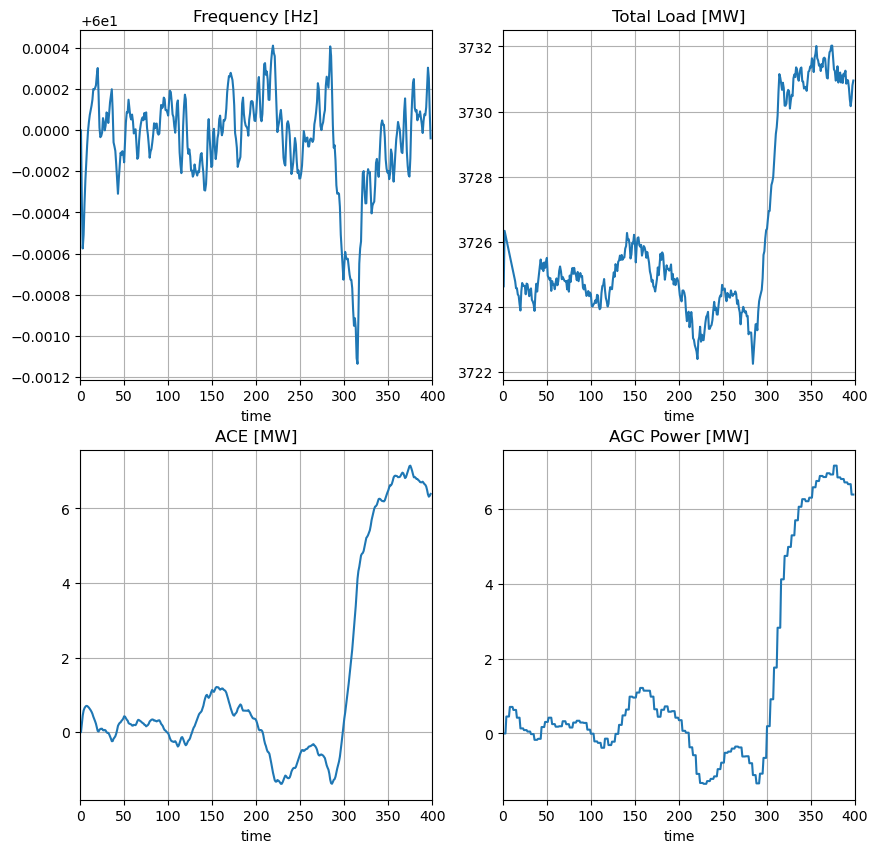

In [18]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10), dpi=100)

outdf.plot(x='time', y='freq', ax=ax[0, 0],
           title='Frequency [Hz]', grid=True,
           xlim=[0, total_time], legend=False)

outdf.plot(x='time', y='pd', ax=ax[0, 1],
           title='Total Load [MW]', grid=True,
           xlim=[0, total_time], legend=False)

outdf.plot(x='time', y='ACEraw', ax=ax[1, 0],
           title='ACE [MW]', grid=True,
           xlim=[0, total_time], legend=False)

outdf.plot(x='time', y='AGCpower', ax=ax[1, 1],
           title='AGC Power [MW]', grid=True,
           xlim=[0, total_time], legend=False)